In [2]:
%%capture --no-stderr
%pip install -q -U langgraph langchain-google-genai


In [3]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm:ChatGoogleGenerativeAI=ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    api_key= google_api_key
)


In [5]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing import TypedDict
class TravelState(TypedDict):
  messages : Annotated[list, add_messages]
  city : str
  interests : list[str]
  itinerary : str
  days : int
  persons : int

In [6]:
from langchain_core.messages import HumanMessage, AIMessage
def get_city_input(state : TravelState):
  """Prompts the user to enter the city they want to visit."""
  print("Enter the city you want to visit:")
  city = input("City:")
  return {
      "city" : city,
      "messages" : state['messages'] + [HumanMessage(content=city)]
      }

In [7]:
def get_number_of_days(state: TravelState):
  """Prompts the user to enter the number of days for the trip."""
  print(f"Please enter the number of days for your trip to {state['city']}:")
  num_days = input("Number of Days:")
  return {
      "days": num_days,
      "messages" : state['messages'] + [HumanMessage(content=num_days)]
          }

In [8]:
def get_number_of_persons(state: TravelState):
  """Prompts the user to enter the number of persons for the trip."""
  print(f"Enter the number of persons for the trip to {state['city']}:")
  num_persons = input("Number of Persons:")
  return {
      "persons": num_persons,
      "messages" : state['messages'] + [HumanMessage(content=num_persons)]
          }

In [9]:
def get_interests_input(state: TravelState):
  """Prompts the user to enter their interests for the trip."""
  print(f"Enter your interests fot the trip to {state['city']}")
  interests = input("Interests (comma-separated): ")
  return {
      "interests": [interests],
      "messages" : state['messages'] + [HumanMessage(content=interests)]
          }

In [15]:
from langchain_core.messages import SystemMessage, HumanMessage
def itinerary_generation(state : TravelState):
  """Generates an itinerary for the user's trip."""
  city = state["city"]
  interests = state["interests"]
  days = state["days"]
  persons = state["persons"]

  print(f"Generating a {days}-day itinerary for {city}, tailored to the interests: {interests}.")
  prompt = f"""Create a personalized trip itinerary tailored to the user based on the provided city, interests, number of days, and number of persons. Include activities,
   dining recommendations, and sightseeing spots that align with the interests, ensuring the itinerary is well-paced and enjoyable.
    City: {city}, Interests: {interests}, Number of Days: {days}, Number of Persons: {persons}."""
  response =  generation = llm.invoke(prompt.format(city=city, interests=interests))

  print("\nFinal Itinerary:")
  print(response.content)

  return {
      "itinerary": response,
      "messages" : state['messages'] + [AIMessage(content=response.content)]
          }




In [16]:
from langgraph.graph import StateGraph, START, END

builder: StateGraph = StateGraph(TravelState)

builder.add_node("City", get_city_input)
builder.add_node("Days", get_number_of_days)
builder.add_node("Persons", get_number_of_persons)
builder.add_node("Interests", get_interests_input)
builder.add_node("Itinerary", itinerary_generation)

builder.add_edge(START, "City")
builder.add_edge("City", "Days")
builder.add_edge("Days", "Persons")
builder.add_edge("Persons", "Interests")
builder.add_edge("Interests", "Itinerary")
builder.add_edge("Itinerary", END)
graph = builder.compile()

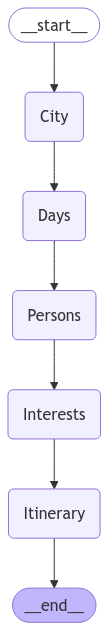

In [12]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    for output in graph.stream(state):
        pass  # The nodes themselves now handle all printing

In [19]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)


Initial Request: I want to plan a day trip.

Enter the city you want to visit:
City:New York
Please enter the number of days for your trip to New York:
Number of Days:3
Enter the number of persons for the trip to New York:
Number of Persons:2
Enter your interests fot the trip to New York
Interests (comma-separated): I want to explore the city, I want to try new food
Generating a 3-day itinerary for New York, tailored to the interests: ['I want to explore the city, I want to try new food'].

Final Itinerary:
## New York City Adventure for Two: 3-Day Itinerary

This itinerary focuses on exploring NYC and indulging in diverse culinary experiences, perfect for a couple with 3 days to spare.  It balances iconic sights with opportunities for spontaneous discovery.

**Day 1: Midtown Marvels & Culinary Delights**

* **Morning (9:00 AM):** Start your day at **Times Square**, soak in the energy, and grab a quick coffee and pastry from a local bakery.
* **Late Morning (10:30 AM):** Visit the **To